# ANN with Fashion MNIST

<img src="img/00_title.PNG">

In [1]:
import os
import gzip # .gz 확장자로 끝나는 압축파일을 열 때 사용한다.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 불러오기

In [2]:
f_lst = os.listdir('./data')
path = './data'

In [3]:
f_lst

['fashion-mnist_test.csv',
 'fashion-mnist_train.csv',
 't10k-images-idx3-ubyte.gz',
 't10k-labels-idx1-ubyte.gz',
 'train-images-idx3-ubyte.gz',
 'train-labels-idx1-ubyte.gz']

In [4]:
def load_mnist(path, kind='train'):
    
    data_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    
    with gzip.open(labels_path, 'rb') as f_l:
        labels = np.frombuffer(f_l.read(), dtype=np.uint8, offset=8)
        
    with gzip.open(data_path, 'rb') as f_d:
        data = np.frombuffer(f_d.read(), dtype=np.uint8, offset=16).reshape((len(labels),784))
        
    return data, labels

### 이미지 파일 개별로 저장하기

In [5]:
img_data, img_label = load_mnist('./data', kind='t10k')
print(img_data.shape)
for idx, data in enumerate(zip(img_data, img_label)):
    np.savez(f'./sdata/test/test_{idx}', img=data[0].reshape(28,28), label=data[1])

In [6]:
img_data, img_label = load_mnist('./data', kind='train')
img_data.shape
for idx, data in enumerate(zip(img_data, img_label)):
    np.savez(f'./sdata/train/train_{idx}', img=data[0].reshape(28,28), label=data[1])

# 2. DataLoader 설정하기

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils import data
from torchvision import transforms

from tqdm import tqdm

In [9]:
BATCH_SIZE = 64

In [10]:
class FASHION10(data.Dataset):
    
    def __init__(self, root_dir='./sdata', split='train', transform=False):
        super().__init__()
        self.split = split
        self.root_dir = root_dir
        self.transform = transform
        if self.split == 'train':
            self.train_dir = os.path.join(self.root_dir, "train")
            self.train_img = sorted(os.listdir(os.path.join(self.train_dir)))
            self.train_paths = [os.path.join(self.train_dir, self.train_img[idx])
                               for idx in range(len(self.train_img))]
        
        elif self.split == 'test':
            self.test_dir = os.path.join(self.root_dir, "test")
            self.test_img = sorted(os.listdir(os.path.join(self.test_dir)))
            self.test_paths = [os.path.join(self.test_dir, self.test_img[idx])
                               for idx in range(len(self.test_img))]
        
        else:
            raise NotImplementedError
        
        
    def __len__(self):
        if self.split == 'train':
            return len(self.train_img)
        elif self.split == 'test':
            return len(self.test_img)
        else:
            raise NotImplementedError
        
        return len(self.npz_lst)
    
    
    def __getitem__(self, idx):
        img, label = self.pairing(idx)
        
        pair = {'img': img, 'label':label}
        
        if self.transform:
            pair = self.transform_totensor(pair)
    
        return pair
    
    
    def pairing(self, idx):
        if self.split == 'train':
            img, label = np.load(self.train_paths[idx]).values()
            return img, label
        
        elif self.split == 'test':
            img, label = np.load(self.test_paths[idx]).values()
            return img, label
        
    def transform_totensor(self, pair):
        original_transforms = transforms.Compose([
            transforms.ToTensor()
        ])
        
        label_transforms = transforms.Compose([
            transforms.ToTensor()
        ])

        _img, _label = original_transforms(pair['img']), torch.from_numpy(pair['label']).long()
        return {'img':_img, 'label':_label}

In [11]:
# transform = transforms.Compose([transforms.ToTensor()])
#transform = None
print('loading Train Set')
train_loader = data.DataLoader(
    dataset = FASHION10(split='train', transform=True),
    batch_size = BATCH_SIZE,
    shuffle = True
)

print('loading Test Set')
test_loader = data.DataLoader(
    dataset = FASHION10(split='test', transform=True),
    batch_size = BATCH_SIZE,
    shuffle = True
)

loading Train Set
loading Test Set


# 3. 모델 구축 및 학습하기

In [12]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

True


In [13]:
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [14]:
EPOCHS = 30

In [15]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
model = ANN().to(DEVICE)

In [17]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [18]:
def train(model, train_loader, optimizer):
    train_loss = 0.0
    train_losses = []
    model.train()
    with tqdm(total=len(train_loader)) as tbar:        
        for batch_idx, sample in enumerate(train_loader):
            img = sample['img'].to(DEVICE)
            label = sample['label'].to(DEVICE)
            
            optimizer.zero_grad()
            output = model(img)
            
            loss = F.cross_entropy(output, label)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            tbar.set_description('Train loss: %.3f'%(train_loss/(batch_idx+1)))
            tbar.update(1)
    train_loss /= (batch_idx+1)
    train_losses.append(train_loss)
    print('[Epoch: %d, numImages: %5d]' % (epoch, batch_idx * BATCH_SIZE + img.data.shape[0]))
    print('Loss: %.3f' % train_loss)
    
    return train_losses

In [19]:
def test(model, test_loader):
    test_loss = 0.0
    correct = 0
    test_losses = []
    model.eval()
    with tqdm(total=len(test_loader)) as tbar:
        for batch_idx, sample in enumerate(test_loader):
            img = sample['img'].to(DEVICE)
            label = sample['label'].to(DEVICE)
            
            with torch.no_grad():
                output = model(img)
            
            loss = F.cross_entropy(output, label)
            
            test_loss += loss.item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(label.view_as(pred)).sum().item()
            
            tbar.set_description('Test loss: %.3f'%(test_loss/(batch_idx+1)))
            tbar.update(1)
    test_loss /= (batch_idx+1)
    test_losses.append(test_loss)
    print('[Epoch: %d, numImages: %5d]' % (epoch, batch_idx * BATCH_SIZE + img.data.shape[0]))
    print('Loss: %.3f' % test_loss)
    print('ACC: %.3f' % (100. * correct / len(test_loader.dataset)))
    
    return test_losses

In [20]:
train_loss_lst = list()
test_loss_lst = list()
for epoch in range(1, EPOCHS+1):
    train_loss_lst.append(train(model, train_loader, optimizer))
    test_loss_lst.append(test(model, test_loader))

Test loss: 0.508:   1%|▊                                                               | 2/157 [00:00<00:08, 18.18it/s]

[Epoch: 1, numImages: 60000]
Loss: 0.682


Train loss: 0.501:   0%|▏                                                              | 2/938 [00:00<00:55, 16.95it/s]

[Epoch: 1, numImages: 10000]
Loss: 0.501
ACC: 81.910


Test loss: 0.401:   1%|▊                                                               | 2/157 [00:00<00:08, 18.69it/s]

[Epoch: 2, numImages: 60000]
Loss: 0.427


Train loss: 0.448:   0%|▏                                                              | 2/938 [00:00<00:56, 16.53it/s]

[Epoch: 2, numImages: 10000]
Loss: 0.428
ACC: 84.870


Test loss: 0.413:   1%|▊                                                               | 2/157 [00:00<00:08, 18.18it/s]

[Epoch: 3, numImages: 60000]
Loss: 0.376


Train loss: 0.394:   0%|▏                                                              | 2/938 [00:00<00:55, 16.81it/s]

[Epoch: 3, numImages: 10000]
Loss: 0.426
ACC: 84.940


Test loss: 0.414:   1%|▊                                                               | 2/157 [00:00<00:08, 18.52it/s]

[Epoch: 4, numImages: 60000]
Loss: 0.349


Train loss: 0.373:   0%|▏                                                              | 2/938 [00:00<00:55, 16.95it/s]

[Epoch: 4, numImages: 10000]
Loss: 0.402
ACC: 85.420


Test loss: 0.323:   1%|▊                                                               | 2/157 [00:00<00:08, 18.33it/s]

[Epoch: 5, numImages: 60000]
Loss: 0.327


Train loss: 0.224:   0%|▏                                                              | 2/938 [00:00<00:55, 16.95it/s]

[Epoch: 5, numImages: 10000]
Loss: 0.367
ACC: 86.760


Test loss: 0.384:   2%|█▏                                                              | 3/157 [00:00<00:08, 18.69it/s]

[Epoch: 6, numImages: 60000]
Loss: 0.313


Train loss: 0.263:   0%|▏                                                              | 2/938 [00:00<00:55, 16.95it/s]

[Epoch: 6, numImages: 10000]
Loss: 0.364
ACC: 86.770


Test loss: 0.335:   1%|▊                                                               | 2/157 [00:00<00:08, 18.35it/s]

[Epoch: 7, numImages: 60000]
Loss: 0.300


Train loss: 0.302:   0%|▏                                                              | 2/938 [00:00<00:56, 16.53it/s]

[Epoch: 7, numImages: 10000]
Loss: 0.358
ACC: 87.160


Test loss: 0.228:   1%|▊                                                               | 2/157 [00:00<00:08, 18.52it/s]

[Epoch: 8, numImages: 60000]
Loss: 0.287


Train loss: 0.290:   0%|▏                                                              | 2/938 [00:00<00:55, 16.81it/s]

[Epoch: 8, numImages: 10000]
Loss: 0.344
ACC: 87.480


Test loss: 0.328:   1%|▊                                                               | 2/157 [00:00<00:08, 17.39it/s]

[Epoch: 9, numImages: 60000]
Loss: 0.279


Train loss: 0.241:   0%|▏                                                              | 2/938 [00:00<00:55, 16.95it/s]

[Epoch: 9, numImages: 10000]
Loss: 0.343
ACC: 87.640


Test loss: 0.379:   1%|▊                                                               | 2/157 [00:00<00:08, 18.52it/s]

[Epoch: 10, numImages: 60000]
Loss: 0.270


Train loss: 0.213:   0%|▏                                                              | 2/938 [00:00<00:54, 17.24it/s]

[Epoch: 10, numImages: 10000]
Loss: 0.333
ACC: 87.930


Test loss: 0.316:   1%|▊                                                               | 2/157 [00:00<00:08, 18.52it/s]

[Epoch: 11, numImages: 60000]
Loss: 0.258


Train loss: 0.242:   0%|▏                                                              | 2/938 [00:00<00:55, 16.81it/s]

[Epoch: 11, numImages: 10000]
Loss: 0.336
ACC: 87.790


Test loss: 0.273:   1%|▊                                                               | 2/157 [00:00<00:08, 18.02it/s]

[Epoch: 12, numImages: 60000]
Loss: 0.249


Train loss: 0.210:   0%|▏                                                              | 2/938 [00:00<00:55, 16.95it/s]

[Epoch: 12, numImages: 10000]
Loss: 0.333
ACC: 87.940


Test loss: 0.243:   1%|▊                                                               | 2/157 [00:00<00:08, 18.52it/s]

[Epoch: 13, numImages: 60000]
Loss: 0.243


Train loss: 0.203:   0%|▏                                                              | 2/938 [00:00<00:54, 17.09it/s]

[Epoch: 13, numImages: 10000]
Loss: 0.341
ACC: 87.800


Test loss: 0.294:   1%|▊                                                               | 2/157 [00:00<00:08, 18.69it/s]

[Epoch: 14, numImages: 60000]
Loss: 0.237


Train loss: 0.156:   0%|▏                                                              | 2/938 [00:00<00:56, 16.67it/s]

[Epoch: 14, numImages: 10000]
Loss: 0.321
ACC: 88.650


Test loss: 0.374:   2%|█▏                                                              | 3/157 [00:00<00:08, 18.87it/s]

[Epoch: 15, numImages: 60000]
Loss: 0.229


Train loss: 0.185:   0%|▏                                                              | 2/938 [00:00<00:53, 17.54it/s]

[Epoch: 15, numImages: 10000]
Loss: 0.324
ACC: 88.620


Test loss: 0.282:   2%|█▏                                                              | 3/157 [00:00<00:08, 18.51it/s]

[Epoch: 16, numImages: 60000]
Loss: 0.223


Train loss: 0.204:   0%|▏                                                              | 2/938 [00:00<00:52, 17.70it/s]

[Epoch: 16, numImages: 10000]
Loss: 0.329
ACC: 88.350


Test loss: 0.242:   1%|▊                                                               | 2/157 [00:00<00:08, 18.69it/s]

[Epoch: 17, numImages: 60000]
Loss: 0.217


Train loss: 0.238:   0%|▏                                                              | 2/938 [00:00<00:55, 16.95it/s]

[Epoch: 17, numImages: 10000]
Loss: 0.328
ACC: 88.750


Test loss: 0.334:   1%|▊                                                               | 2/157 [00:00<00:08, 18.52it/s]

[Epoch: 18, numImages: 60000]
Loss: 0.210


Train loss: 0.194:   0%|▏                                                              | 2/938 [00:00<00:55, 16.81it/s]

[Epoch: 18, numImages: 10000]
Loss: 0.320
ACC: 88.850


Test loss: 0.289:   1%|▊                                                               | 2/157 [00:00<00:08, 18.59it/s]

[Epoch: 19, numImages: 60000]
Loss: 0.207


Train loss: 0.203:   0%|▏                                                              | 2/938 [00:00<00:54, 17.24it/s]

[Epoch: 19, numImages: 10000]
Loss: 0.318
ACC: 89.120


Test loss: 0.387:   1%|▊                                                               | 2/157 [00:00<00:08, 18.18it/s]

[Epoch: 20, numImages: 60000]
Loss: 0.200


Train loss: 0.217:   0%|▏                                                              | 2/938 [00:00<00:55, 16.95it/s]

[Epoch: 20, numImages: 10000]
Loss: 0.325
ACC: 88.740


Test loss: 0.285:   1%|▊                                                               | 2/157 [00:00<00:08, 18.02it/s]

[Epoch: 21, numImages: 60000]
Loss: 0.196


Train loss: 0.161:   0%|▏                                                              | 2/938 [00:00<00:55, 16.81it/s]

[Epoch: 21, numImages: 10000]
Loss: 0.330
ACC: 88.930


Test loss: 0.368:   1%|▊                                                               | 2/157 [00:00<00:08, 18.69it/s]

[Epoch: 22, numImages: 60000]
Loss: 0.189


Train loss: 0.128:   0%|▏                                                              | 2/938 [00:00<00:56, 16.67it/s]

[Epoch: 22, numImages: 10000]
Loss: 0.321
ACC: 88.840


Test loss: 0.351:   1%|▊                                                               | 2/157 [00:00<00:08, 18.19it/s]

[Epoch: 23, numImages: 60000]
Loss: 0.183


Train loss: 0.151:   0%|▏                                                              | 2/938 [00:00<00:55, 16.95it/s]

[Epoch: 23, numImages: 10000]
Loss: 0.320
ACC: 88.710


Test loss: 0.383:   1%|▊                                                               | 2/157 [00:00<00:08, 18.52it/s]

[Epoch: 24, numImages: 60000]
Loss: 0.180


Train loss: 0.164:   0%|▏                                                              | 2/938 [00:00<00:54, 17.09it/s]

[Epoch: 24, numImages: 10000]
Loss: 0.338
ACC: 88.480


Test loss: 0.423:   1%|▊                                                               | 2/157 [00:00<00:08, 18.52it/s]

[Epoch: 25, numImages: 60000]
Loss: 0.176


Train loss: 0.311:   0%|▏                                                              | 2/938 [00:00<00:55, 16.81it/s]

[Epoch: 25, numImages: 10000]
Loss: 0.370
ACC: 87.700


Test loss: 0.230:   2%|█▏                                                              | 3/157 [00:00<00:08, 18.87it/s]

[Epoch: 26, numImages: 60000]
Loss: 0.173


Train loss: 0.121:   0%|▏                                                              | 2/938 [00:00<00:56, 16.53it/s]

[Epoch: 26, numImages: 10000]
Loss: 0.323
ACC: 89.240


Test loss: 0.365:   2%|█▏                                                              | 3/157 [00:00<00:08, 18.02it/s]

[Epoch: 27, numImages: 60000]
Loss: 0.169


Train loss: 0.256:   0%|▏                                                              | 2/938 [00:00<00:55, 16.81it/s]

[Epoch: 27, numImages: 10000]
Loss: 0.347
ACC: 89.380


Test loss: 0.460:   2%|█▏                                                              | 3/157 [00:00<00:08, 18.52it/s]

[Epoch: 28, numImages: 60000]
Loss: 0.163


Train loss: 0.189:   0%|▏                                                              | 2/938 [00:00<00:52, 17.70it/s]

[Epoch: 28, numImages: 10000]
Loss: 0.333
ACC: 89.510


Test loss: 0.400:   1%|▊                                                               | 2/157 [00:00<00:08, 18.52it/s]

[Epoch: 29, numImages: 60000]
Loss: 0.160


Train loss: 0.127:   0%|▏                                                              | 2/938 [00:00<00:55, 16.95it/s]

[Epoch: 29, numImages: 10000]
Loss: 0.326
ACC: 89.380


Test loss: 0.187:   1%|▊                                                               | 2/157 [00:00<00:08, 18.18it/s]

[Epoch: 30, numImages: 60000]
Loss: 0.157


Test loss: 0.342: 100%|██████████████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.26it/s]

[Epoch: 30, numImages: 10000]
Loss: 0.342
ACC: 89.330


# 4. 학습 결과

In [26]:
train_loss_lst = [i[0] for i in train_loss_lst]
test_loss_lst = [i[0] for i in test_loss_lst]

Text(0.5, 1.0, 'FashionMNIST with ANN')

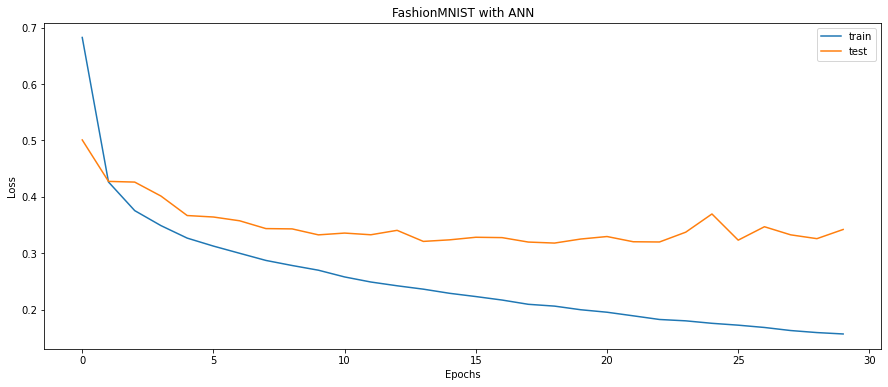

In [32]:
plt.figure(figsize=(15,6))
plt.plot(train_loss_lst)
plt.plot(test_loss_lst)
plt.legend(['train','test'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('FashionMNIST with ANN')